# Credit analysis

The goal is to fit a statistical model to historical credit data and then use the model to estimate the value of current loans.

The task is broken up into five steps which are explained in detail below.

In [62]:
#IMPORTING OF LIBRARIES
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
#Observation of the data
data = pd.read_csv("https://raw.githubusercontent.com/GennadiiTurutin/credit-analysis-task/master/data_science_task.csv")
data.head()

,account_no,gender,age,income,loan_amount,term,installment_amount,interest_rate,credit_score_at_application,outstanding_balance,status
0,acc_00000316,F,18,12143,47000,60,1045,0.12,860,0,PAID_UP
1,acc_00000422,F,18,6021,13000,60,330,0.18,640,0,PAID_UP
2,acc_00001373,F,39,12832,13000,60,296,0.13,820,0,PAID_UP
3,acc_00001686,F,33,4867,5000,36,191,0.22,540,0,PAID_UP
4,acc_00001733,F,23,5107,22000,36,818,0.20,580,11314,LIVE


account_no - A unique account number per loan

gender - The gender of the account holder - either ‘M’ or ‘F’

age - The age of the account holder at the point of application

income - The monthly nett income of the account holder at the point of application

loan_amount - The amount of money lent

term - The number of months that the loan is to be repaid over

installment_amount - The monthly installment amount

insterest_rate - The interest rate on the loan

credit_score_at_application -The credit score at the point of application, this is a positive integer less than 1000. 
The higher the score the more creditworthy the applicant is believed to be.

outstanding_balance - The remaining amount of the loan that still has to be repaid

status - This indicates what state the account is in. This field can take one of three values

    “LIVE”: The loan is still being repaid - the field outstanding_balance will be greater than zero.
    
    “PAID_UP”: The loan has been completely repaid - the field outstanding_balance will be zero.
    
     “DEFAULT”: The loan was not fully repaid and no further payments can be expected - the field outstanding_balance will be   greater than zero and the amount will not be recoverable.

In our data we see information that clearly doesn't affect the results anyhow. 
For instance, we could easily do away with account_no. 

Pay attention to the column "outstanding_balance", which we shouldn't use 
as this field is by definition perfectly correlated with the default variable you are trying to predict. But we'll keep this column for future calculations. 

In [68]:
data.drop(data[["account_no"]], axis = 1, inplace = True)

Let's check our data for missing values.

In [69]:
data.isnull().values.any()

False

In [70]:
data.dtypes

gender                          object
age                              int64
income                           int64
loan_amount                      int64
term                             int64
installment_amount               int64
interest_rate                  float64
credit_score_at_application      int64
outstanding_balance              int64
status                          object
dtype: object

In [71]:
pd.value_counts(data.status.values)

PAID_UP    9308
LIVE       2001
DEFAULT     689
dtype: int64

As we see, our data is highly imbalanced. For imbalanced data different strategies could be used: 

resampling, generating synthetic samples, different algorithms, penalizing models, etc. 

To cope with imbalance, down the line we'll set the algorithm parameter class_weight equal to "auto".

PAID_UP    9308
LIVE       2001
DEFAULT     689
Name: status, dtype: int64


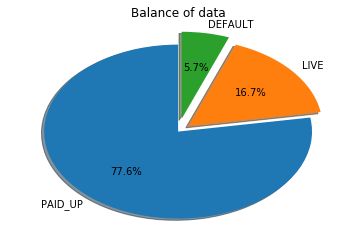

In [72]:
print(data.status.value_counts())

plt.pie([9308, 2001, 689], 
        labels=["PAID_UP", "LIVE", "DEFAULT"], 
        startangle=90, 
        shadow=True, 
        explode=(0,0.1, 0.15),
        autopct='%1.1f%%')
plt.title('Balance of data')

For compehension of the dataset, it could be instrumental to visualize data.
In our case the most interesting is to glimpse income distribution.

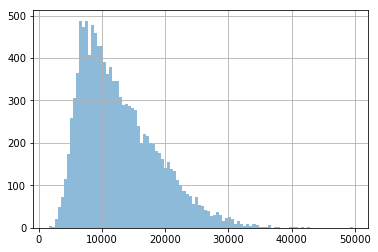

In [73]:
#Visualization
data["income"].hist(bins = 100, alpha = 0.5)

Also we can use seaborn to get a more detailed picture of the distribution. 

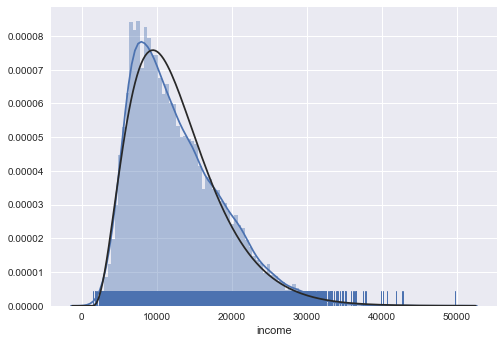

In [74]:
from scipy import stats
import seaborn as sns 
sns.set(color_codes=True)
sns.distplot(data.income, bins=100, kde=True, rug=True, fit=stats.gamma)

We can plot pairwise relationships in a dataset.

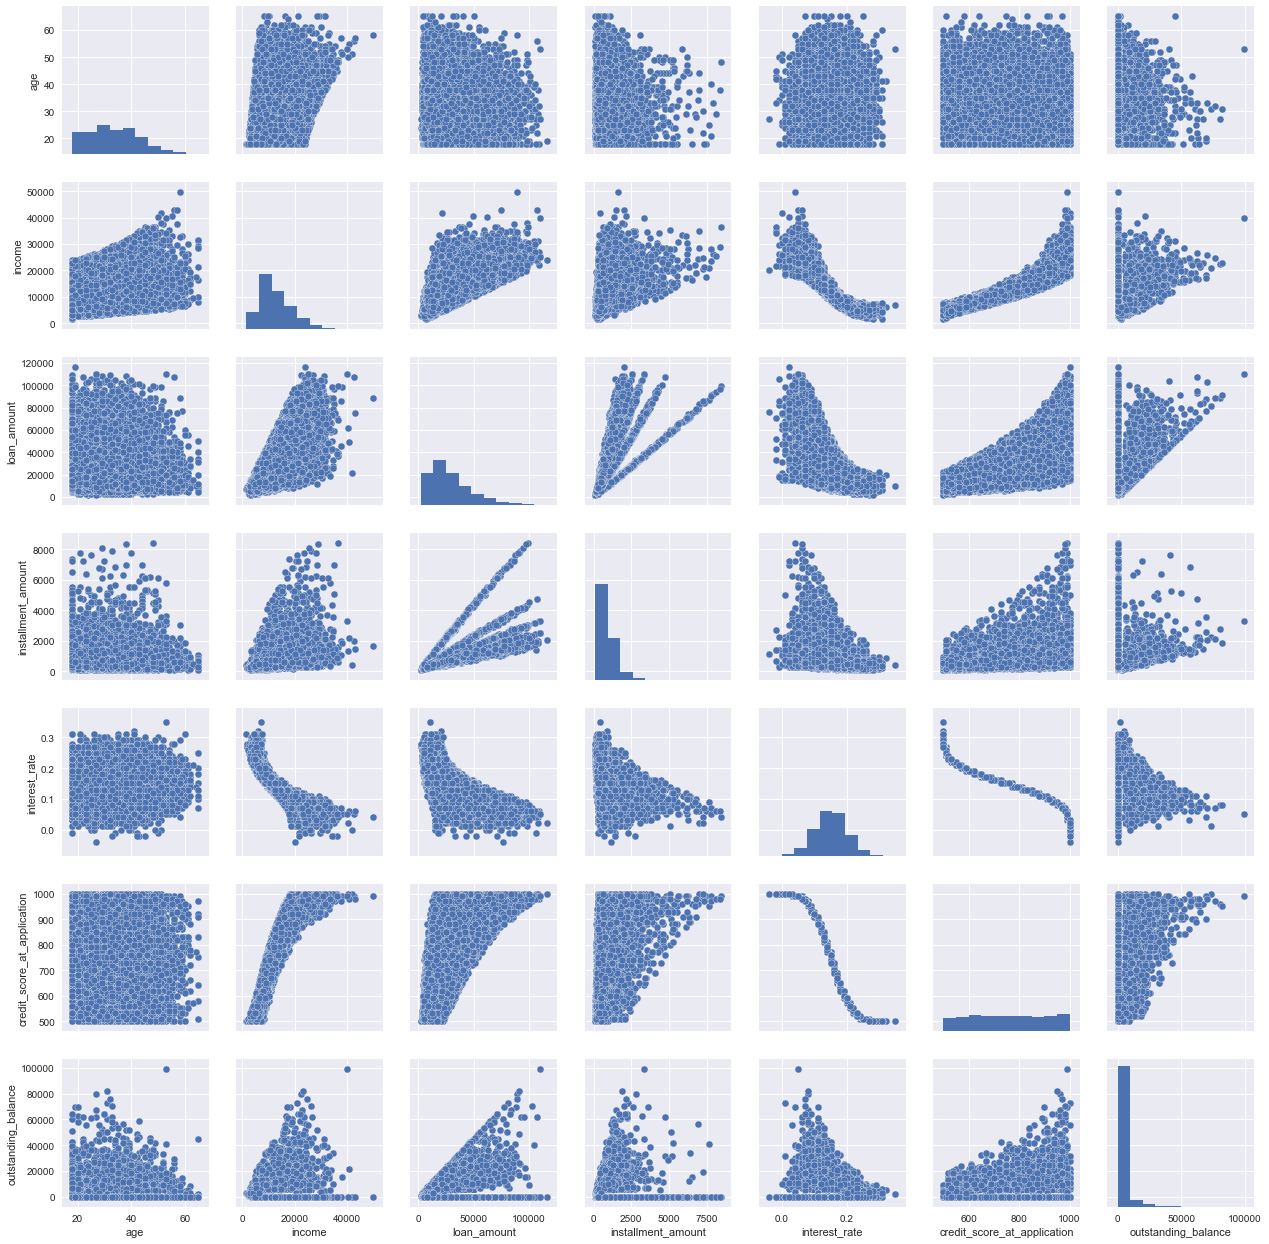

In [10]:
cols = ["age", "income", "loan_amount", "installment_amount", "interest_rate", "credit_score_at_application", "outstanding_balance"]
import seaborn as sns
sns_plot = sns.pairplot(data[cols])

If we want to see, whether the distribution is normal, then we can do normaltest from stats. 

In [11]:
stats.mstats.normaltest(data.income)

NormaltestResult(statistic=1386.7071188911243, pvalue=7.5923308463129237e-302)

Let's take a look at the means of income for different types of customers. For this purpose we can use barplot or boxplot.

([<matplotlib.axis.XTick at 0x2c1dcfa4f98>,
 <a list of 3 Text xticklabel objects>)

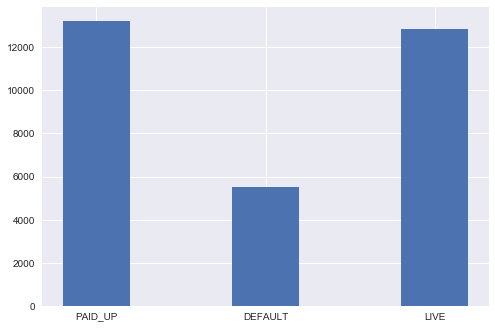

In [12]:
names = ["PAID_UP", "DEFAULT", "LIVE"]
means = []
for _ in names:
    means.append(np.array(data.income[data.status == _ ].mean()))
    
plt.bar([0,1,2], means, width = 0.4)
my_xticks = ['PAID_UP','DEFAULT','LIVE']
plt.xticks([0,1,2], my_xticks)

Boxplot

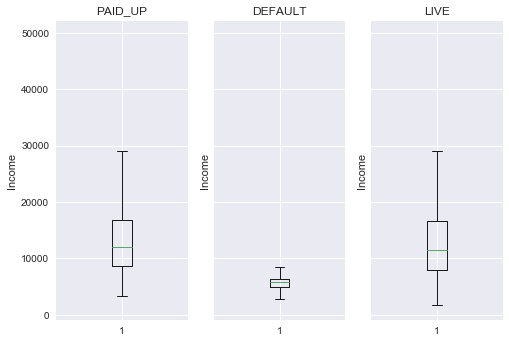

In [13]:
status = []
for _ in names:
    status.append(np.array(data.income[data.status == _ ]))
    
fig, (axes) = plt.subplots(nrows=1, ncols=3, sharey = True)
i=0
for axis in axes: 
    axis.boxplot(status[i])
    axis.set_title(names[i])
    axis.set_ylabel("Income") 
    i+=1
    

Now we are separating the data into two data sets, using the status field: a current and a historical data set. 

Historical data has status “PAID_UP” or “DEFAULT”, current data has the status “LIVE”.

In [3]:
is_hist = []
for status in data.status:
    if status == "PAID_UP":
        is_hist.append(True)
    elif status == "DEFAULT":
        is_hist.append(True)
    else:
        is_hist.append(False)
        
is_hist = pd.Series(is_hist)  

In [28]:
data[is_hist].head()

,account_no,gender,age,income,loan_amount,term,installment_amount,interest_rate,credit_score_at_application,outstanding_balance,status
0,acc_00000316,F,18,12143,47000,60,1045,0.12,860,0,PAID_UP
1,acc_00000422,F,18,6021,13000,60,330,0.18,640,0,PAID_UP
2,acc_00001373,F,39,12832,13000,60,296,0.13,820,0,PAID_UP
3,acc_00001686,F,33,4867,5000,36,191,0.22,540,0,PAID_UP
5,acc_00002114,M,38,9328,25000,36,904,0.18,630,0,PAID_UP


In [29]:
data[~is_hist].head()

,account_no,gender,age,income,loan_amount,term,installment_amount,interest_rate,credit_score_at_application,outstanding_balance,status
4,acc_00001733,F,23,5107,22000,36,818,0.20,580,11314,LIVE
40,acc_00038217,F,40,15659,33000,48,853,0.11,880,5637,LIVE
41,acc_00039355,M,25,15660,15000,48,395,0.12,860,6039,LIVE
44,acc_00041999,F,30,4208,15000,48,481,0.23,530,2817,LIVE
46,acc_00043452,F,18,6535,12000,48,346,0.17,660,3120,LIVE


If we take a look at our data, we will notice, that some columns have a non-numeric format. Namely gender and status. 
What we can do is to substitute them for binary values. For instance, for values F and M, we can use 0 and 1 respectively. 

In [75]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_h = data[is_hist].iloc[:,0:8].values
Y_h = data[is_hist].iloc[:,9].values

X_h[:,0] = le.fit_transform(X_h[:,0])
Y_h = le.fit_transform(Y_h)

Feature selection

Using decision trees we are able to estimate feature importances and do away with noise

In [6]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_h, Y_h)

for i in range(1, 9):
    print(data.columns[i], model.feature_importances_[i-1])

gender 0.0437458729965
age 0.15192069664
income 0.24368629129
loan_amount 0.0518120587329
term 0.0179513593146
installment_amount 0.0431189451912
interest_rate 0.243979145549
credit_score_at_application 0.203785630286


In [10]:
data.drop(data[["gender", "loan_amount", "installment_amount", "term"]], axis=1, inplace=True)

Now let's see at the correlation of our variables.

Correlation higher than 0.7 or lower than -0.7 could be considered as significant and detrimental for building the model.

In [11]:
data.corr()

,age,income,interest_rate,credit_score_at_application,outstanding_balance
age,1.000000,0.193818,0.012086,-0.010451,-0.023832
income,0.193818,1.000000,-0.901268,0.910796,0.115041
interest_rate,0.012086,-0.901268,1.000000,-0.976295,-0.094837
credit_score_at_application,-0.010451,0.910796,-0.976295,1.000000,0.101903
outstanding_balance,-0.023832,0.115041,-0.094837,0.101903,1.000000


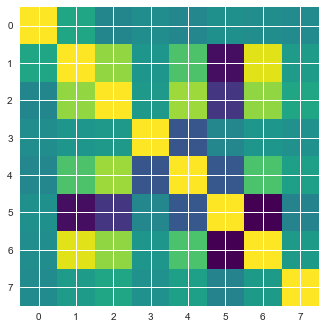

In [15]:
plt.imshow(data.corr(), cmap='viridis')

In [12]:
data.drop(data[["interest_rate", "credit_score_at_application"]], axis=1, inplace=True)

If we compare the values of different columns, we'll notice a huge variance of ranges. 

Time to normalize our data.

We are going to transform the data such that its distribution will have a mean value 0 and standard deviation of 1.

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_h = data[is_hist].iloc[:, 0:2]
X_h = sc.fit_transform(X_h)

Now we have to split X and Y into separate training and test datasets. 

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(X_h, Y_h, test_size = 0.2, random_state = 0)

It's high time to get down to model building. 
We can use any algorithm, that wil allow us to get probability. 
Let's choose Support Vector Machine Classifier. 
Hyperparameters will play a key role here. 
The following parameters are of the most interesting:

    C - learning rate
    kernel - ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
    degree - int, optional (default=3)
    Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
    class_weight - "auto", "balanced"
    gamma - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.
    probability - Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down the method. In our case we chose probability=True

The performance of the algorithm depends extemely on hyperparameters. 
To find the best parameters we utilize GridSearchCV, 
that finds the best combination of parameters according to selected metrics.

For simplicity and faster computation, we will play around only with a few parameters: C and gamma.

In [37]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV


parameters = {'C': np.arange( 1, 10, 1 ).tolist(), 'gamma': np.arange( 0.0, 1.0, 0.1 ).tolist()}
# 'gamma': np.arange( 0.0, 5.0, 0.2 ).tolist()

model = GridSearchCV(SVC(kernel = "rbf", class_weight = "auto", probability = True),
                    parameters,
                    n_jobs               = 5,
                    cv                   = 3,
                    scoring              = 'roc_auc'
                    )   

model.fit(X_train, Y_train)
print("\nThe best estimator: ", model.best_estimator_)
print("\nThe best precision score: ", model.best_score_)
print("\nHighest scoring parameter set: ", model.best_params_)

C:\Users\Home\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Home\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Home\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:65: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)



The best estimator:  SVC(C=9, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.9, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The best precision score:  0.970872797141184

Highest scoring parameter set:  {'C': 9, 'gamma': 0.9}


Now, when we've built the model, 
it's interesting to use the held out data to predict the results for the group of customers with status "LIVE".
We can get prediction and probability for our observations

In [42]:
X_2 = data[~is_hist].iloc[:,0:2]
X_2 = sc.fit_transform(X_2)

model = model.best_estimator_
Y_pred = model.predict(X_2)
Y_prob = model.predict_proba(X_2)

For evaluation of our model we can resort to confusion matrix.

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, model.predict(X_test))
cm

array([[ 126,    4],
       [ 242, 1628]])

The results of our confusion matrix are: 

[0,0] - TRUE POSITIVE - 126 

[0,1] - FALSE POSITIVE - 4

[1,0] - FALSE NEGATIVE - 242

[1,1] - TRUE NEGATIVE - 1628


It means, that out of 130 positive examples 126 were correctly identified.

And out of 1870 negative examples 242 were identified inappropriately. 

Forecasting value of book

Finally, we use our model to predict the probability of default for each of the loans in the current dataset 

and to calculate the expected repayment amount for each loan 

curr_data - a dataset, storing all information pertaining to status "LIVE"

Y_prob - an array, storing probabilities if the loan being paid off, pertaining to current data (status = "LIVE")

amount_repay - an array, storing the product of the probability of being paid off and the outstanding balance (remaining amount of the loan). 

In [47]:
data["prob_of_repayment"] = np.nan
data["amount_repay"] = np.nan
curr_data = data[~is_hist]
curr_data.prob_of_repayment = np.array(Y_prob[:, 1])
curr_data.amount_repay = curr_data.prob_of_repayment * curr_data.outstanding_balance

C:\Users\Home\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [60]:
repay_total = curr_data.amount_repay.sum()
balance_total = curr_data.outstanding_balance.sum()
default_rate_curr = (1 - repay_total / balance_total) * 100
print(" Average default rate for current accounts: ", default_rate_curr)

Average default rate for current accounts:  3.460695347759113


In [61]:
n_default = pd.value_counts(data["status"] == "DEFAULT")[True]
n_paid = pd.value_counts(data["status"] == "PAID_UP")[True]
default_rate_hist = n_default/n_paid * 100
print(" Average default rate for historical accounts: ", default_rate_hist)

Average default rate for historical accounts:  7.40223463687
